[ASHRAE] - Great Energy Predictor |||
----
참고 자료 링크 : https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction

## Introduction

건물은 현재 많은 에너지를 소비하며 이는 돈과 환경에 영향을 많이 미칩니다. 다행히 비용과 배출량을 줄이기 위해 상당한 투자가 이루어지고 있으며 방법은 아래와 같습니다.

에너지 절약 개발에는 두 가지 핵심 요소가 있습니다.
- 별도의 개선없이 미래의 에너지 사용을 예측하는 것
- Investment grade meters의 설치 미 구매와 같은 특정한 개선 장비가 구현된후 미래의 에너지 사용을 예측하는 것.

사실, 에너지 사용 예측을 위한 비용 효율적이고 정확하며 확장 가능한 절차가 없다는 것이 큰 문제입니다. 
이 대회에서는 냉수, 전기, 천연 가스, 온수 및 증기 계량기 등의 분야에서 계량식 건물 에너지 사용량을 정확하게 예측합니다.

## Data

건물이 얼마나 많은 에너지를 사용했는지 알 수 있는 방법이 없기 때문에 에너지 효율 향상의 가치를 평가하는 것은 어려울 수 있습니다.
최선의 방법은 실제 모델을 만든 후 새로운 에너지 소비를 원래 건물과 비교하여 개조 비용을 절감하는 겁니다. 보다 정확한 모델은 더 나은 시장 인센티브를 지원하고 비용을 절감 할 수 있습니다.

이 Competition은 건물들의 사용률과 관측 된 날씨를 기반으로 4가지 에너지에 대한 모델을 구축해야합니다. 이 데이터 세트에는 전 세계 여러 사이트에 있는 천 개가 넘는 건물에서 3년간의 시간별 계량값이 포함됩니다.

## Files
> #### train.csv
- `building_id` - Foreign key for the building metadata.
- `meter` - The meter id code. Read as {0: 전기, 1: 냉각수, 2: 증기, 3: 온수}. 모든 건물에 미터 유형이 있는 것은 아닙니다. ?!
- `timestamp` - When the measurement was taken
- `meter_reading` - The target variable. kWh 단위의 에너지 소비. 이는 측정 오류가 있는 실제 데이터이며, 기준 수준의 모델링 오류가 발생할 것으로 예상된다.

> #### building_meta.csv
- `site_id` - Foreign key for the weather files.
- `building_id` - Foreign key for `training.csv`
- `primary_use` - [EnergyStar](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type) 속성 유형 정의에 따른 건물의 주요 활동 카테고리 표시
- `square_feet` - 건물의 총 바닥 면적
- `year_built` - 개관 연도
- `floor_count` - 층 수

> #### weather_[train/test].csv
- `site_id`
- `air_temperature` - 기온의 섭씨 온도
- `cloud_coverage` - 구름에 의해 가려진 하늘의 일부를 나타냄. [oktas](https://en.wikipedia.org/wiki/Okta)는 클라우드 커버의 일반적인 측정 단위
- `dew_temperature` - 이슬 섭씨 온도 // 아마 이슬점이 되는 온도를 뜻하는거 같음.
- `precip_depth_1_hr` - Millimeters // 시간당 강수량
- `sea_level_pressure` - Millibar/hectopascals // Atmospheric pressure : 대기압
- `wind_direction` - 나침반 방향 (0-360)
- `wind_speed` - Meters per second

> #### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.
- `row_id` - Row id for your submission file
- `building_id` - Building id code
- `meter` - The meter id code
- `timestamp` - Timestamps for the test data period

> ####  sample_submission.csv
A valid sample submission.
소수점 5자리에서 반올림.

> ## Evaluation Metric (평가 지표)
We will be evaluated by the metirc `Root Mean Squared Logarithmic Error`.
The RMSLE is calculated as:
$ ϵ=1n∑i= \sqrt{ 1/n (log(pi+1)−log(ai+1))^2 } $
Where:
- ϵ is the RMSLE value (score)
- n is the total number of observations in the (public/private) data set,
- pi is your prediction of target, and
- ai is the actual target for i.
- log(x) is the natural logarithm of x

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)


py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle

In [3]:
import os
print(os.listdir('./data'))

['weather_train.csv', '.ipynb_checkpoints', 'building_metadata.csv', 'test.csv', 'train.csv', 'weather_test.csv', 'sample_submission.csv', 'data_analysis.ipynb']


In [4]:
%%time
root = './data/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
test_df = pd.read_csv(root + 'test.csv')
weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: user 20.6 s, sys: 1.75 s, total: 22.3 s
Wall time: 14.8 s


In [5]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


In [6]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
## REducing memory
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [8]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [9]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [10]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


In [11]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


## Examine the Distribution of the Target Column

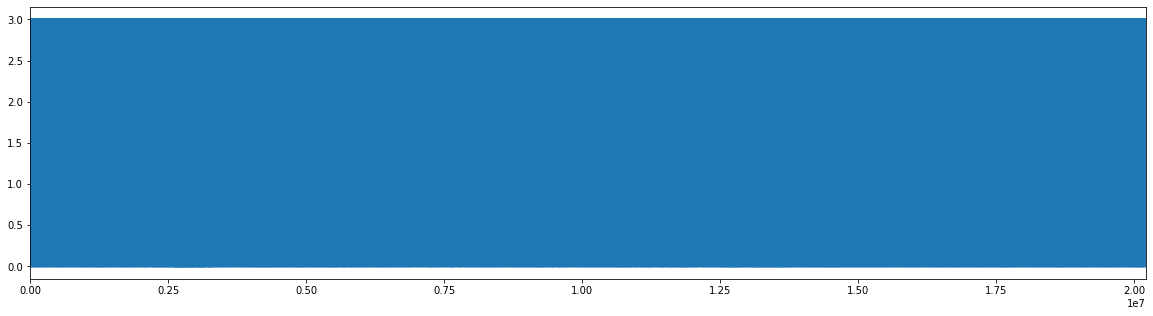

In [12]:
for key, d in train_df.groupby('meter_reading'):
    break
    d.head()
plt.figure(figsize = (20,5))
d['meter'].plot()

meter 값이 고르게 분포되어있다는 것을 알 수 있다.

In [13]:
train_df['meter_reading'].describe()

count    2.021610e+07
mean     2.117122e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

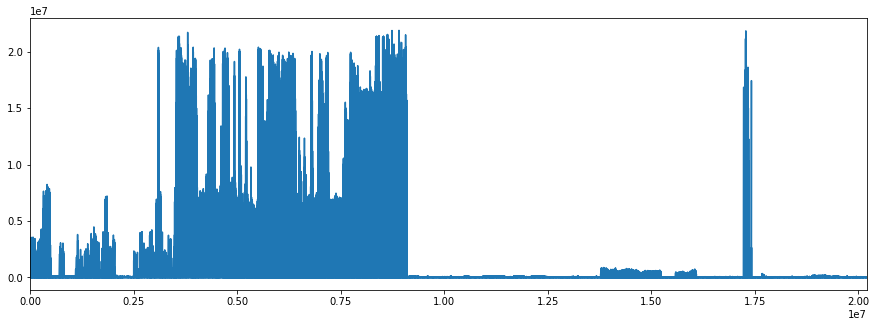

In [14]:
plt.figure(figsize = (15,5))
train_df['meter_reading'].plot()

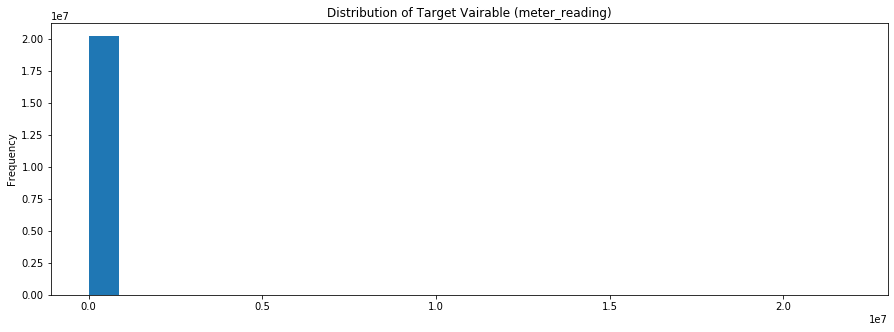

In [15]:
train_df['meter_reading'].plot(kind='hist',
                              bins=25,
                              figsize=(15, 5),
                              title = 'Distribution of Target Vairable (meter_reading)')
plt.show()

대부분 상대적으로 작은 값에 치우쳐져 있다...

## Missing data and zeros visualized

시간에 기반하여 각 건물 및 미터 쌍에 대해 target 이 0인곳과 없는 곳을 시각화합니다. 

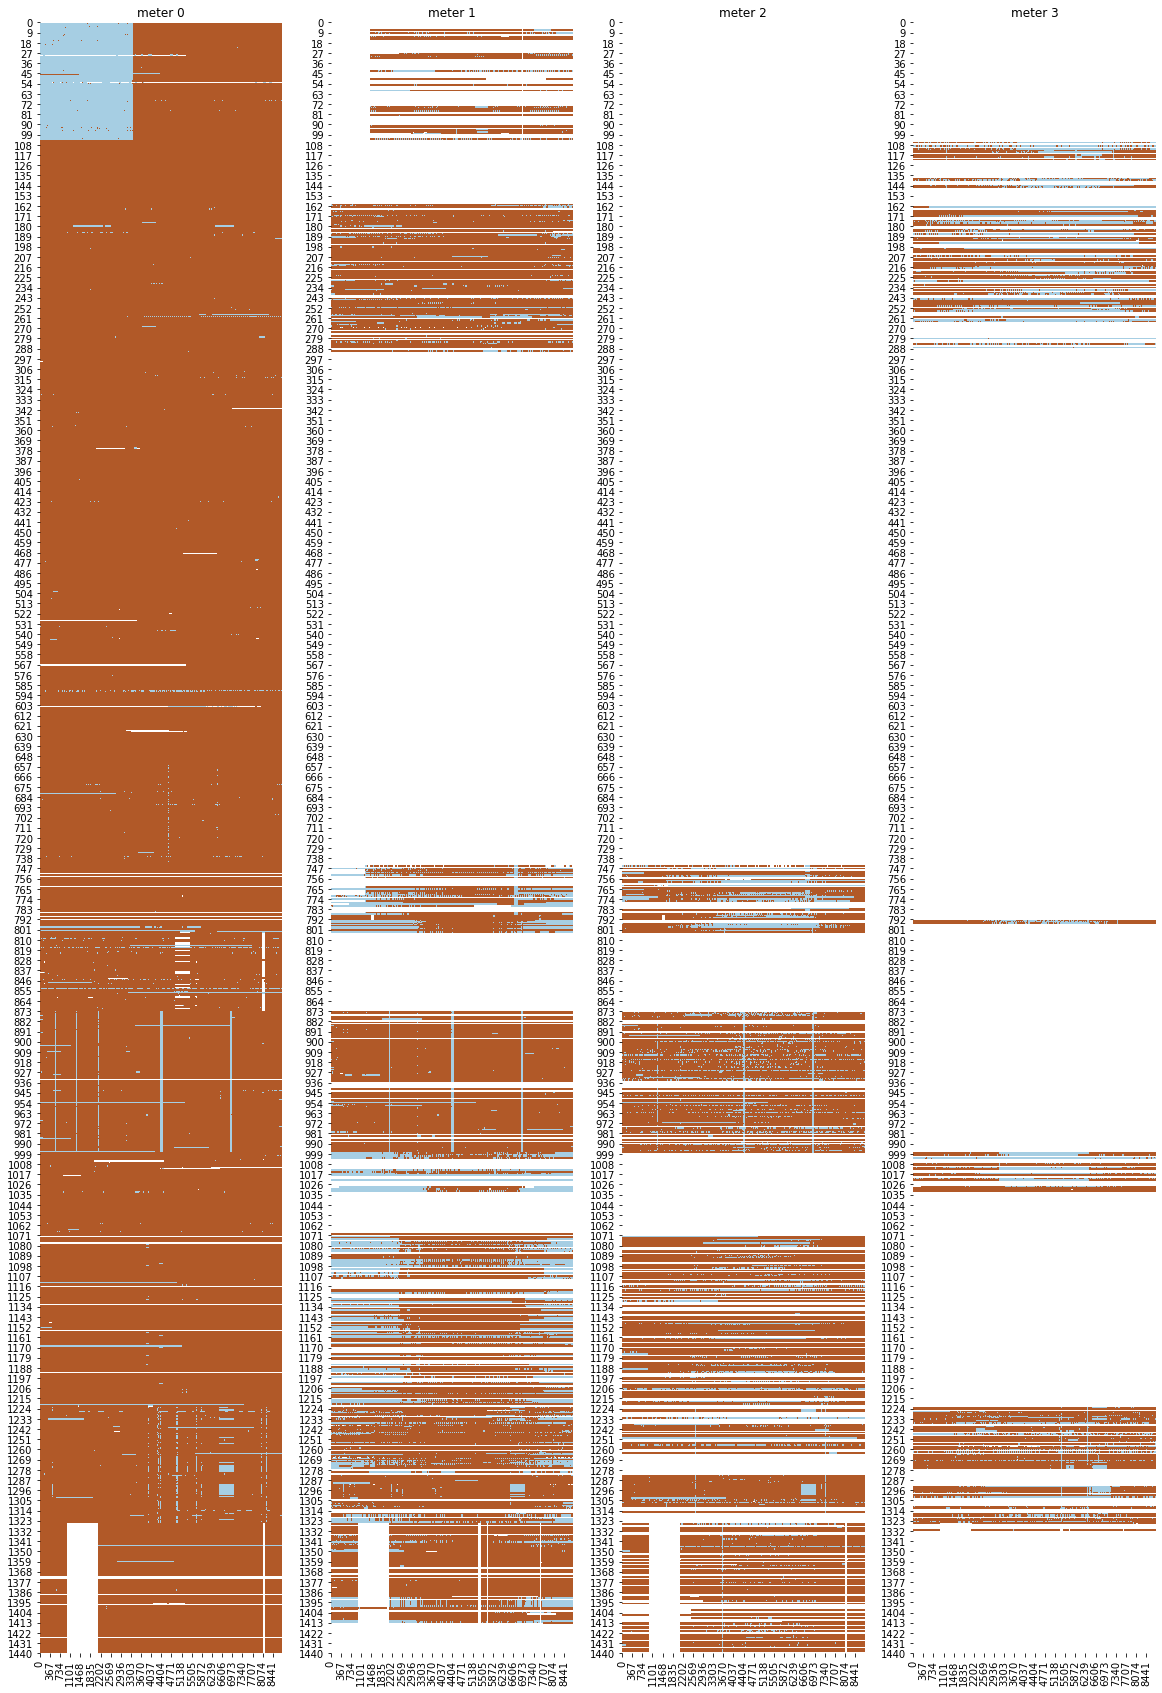

In [16]:
# Load data
train = train_df.set_index(['timestamp'])

# Plot missing values per building/meter
f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df = train[train.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min()
    missmap = np.empty((1449, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values:
        if l[2]!=meter:continue
        missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

##### Legend:

- X axis: TImeStamp
- Y axis: building_id
- Brown: non-zero
- Light blue: zero
- White: missing

{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

## Examine Missing Values

##### train_df

In [17]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(4)

,Total,Percent
meter_reading,0,0.0
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0


##### weather_train_df

In [18]:
# checking missing data
total = weather_train_df.isnull().sum().sort_values(ascending = False)
percent = (weather_train_df.isnull().sum()/weather_train_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_data.head(9)

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


##### weather_test_df

In [19]:
# checking missing data
total = weather_test_df.isnull().sum().sort_values(ascending = False)
percent = (weather_test_df.isnull().sum()/weather_test_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_test_data.head(9)

,Total,Percent
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
timestamp,0,0.000000
site_id,0,0.000000


##### building_meta_df

In [20]:
# checking missing data
total = building_meta_df.isnull().sum().sort_values(ascending = False)
percent = (building_meta_df.isnull().sum()/building_meta_df.isnull().count()*100).sort_values(ascending = False)
missing_building_meta_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_meta_df.head(6)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


## Column Types

Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features.

In [21]:
train_df.dtypes.value_counts()

int8              1
int16             1
datetime64[ns]    1
float32           1
dtype: int64

In [22]:
train_df.select_dtypes('object')

""
0
1
2
3
4
...
20216095
20216096
20216097
20216098


In [23]:
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0) # hmm..

Series([], dtype: float64)

##### Correlations

데이터를 이해하기 위해서 우리는 상관관계를 살펴 볼 수 있다. dataframe의 `.corr` Method를 사용합니다. <br>
상관 계수는 피쳐의 "관련성"을 나타내는 가장 좋은 방법은 아니지만 그래도 우리에게 긍정적인 아이디어를 준다.

- .00 - .19 'very weak'
- .20 - .39 'weak'
- .40 - .59 'moderate'
- .60 - .79 'strong'
- .80 - 1.0 'very strong'

In [24]:
correlations = train_df.corr()['meter_reading'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64

Most Negative Correlations:
 building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64


In [25]:
corrs = train_df.corr()
corrs

,building_id,meter,meter_reading
building_id,1.000000,0.222268,0.008761
meter,0.222268,1.000000,0.017672
meter_reading,0.008761,0.017672,1.000000


Text(0.5, 1, 'Correlation Heatmap')

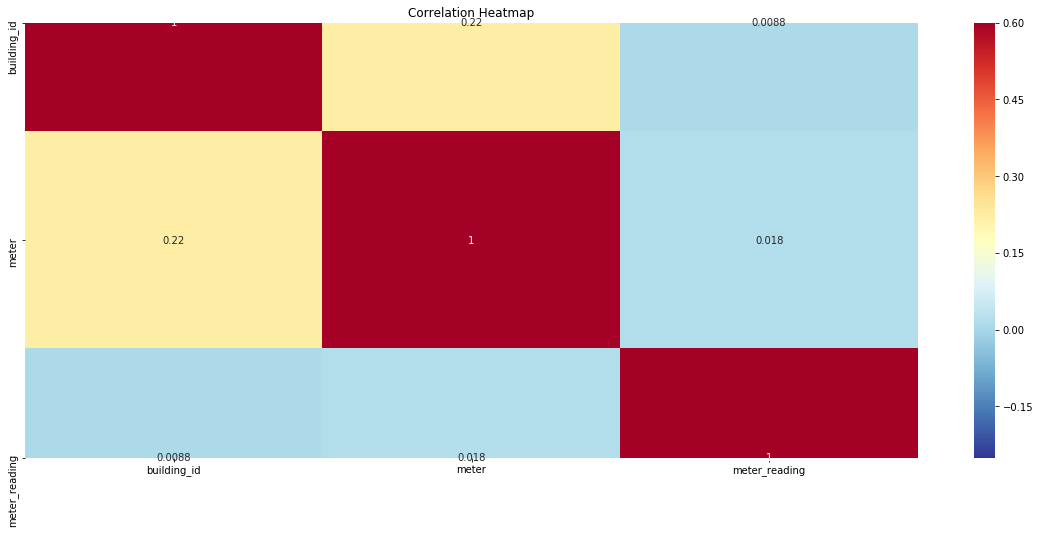

In [28]:
plt.figure(figsize = (20, 8))

sns.heatmap(corrs, cmap= plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6) # vmin , vmax 가 왼쪽의 colorbar 조절, annot 은 percent 보여줌
plt.title('Correlation Heatmap') # 세미콜론 붙이니 Text(0.5 ...) 사라짐

## Ploting

In [37]:
train_df.building_id.nunique(), len(set(train_df.building_id)) # Return number of unique elements in the object. 확실히 왼쪽 코드가 속도가 훨씬 빠르다.

(1449, 1449)

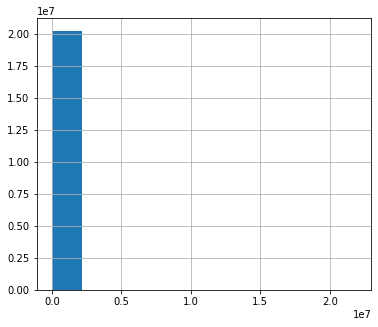

In [41]:
train_df['meter_reading'].hist(figsize = (6, 5))

In [44]:
def plot_dist_col(column):
    ''' 주어진 열에 대해 [train/test] weather data에 대한 곡선 그래프를 그림'''
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.distplot(weather_train_df[column].dropna(), color='green', ax = ax).set_title(column, fontsize = 16)
    sns.distplot(weather_test_df[column].dropna(), color='purple', ax = ax).set_title(column, fontsize = 16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()

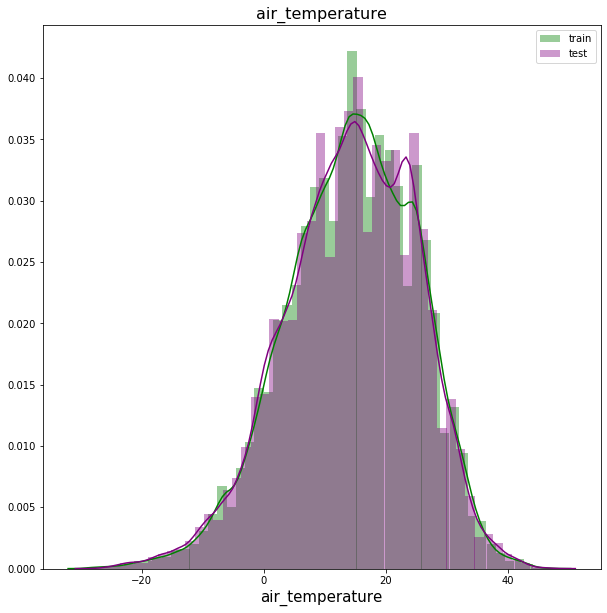

In [45]:
plot_dist_col('air_temperature')

테스트셋과 트레인셋의 차이가 그렇게 크지 않아 보입니다.

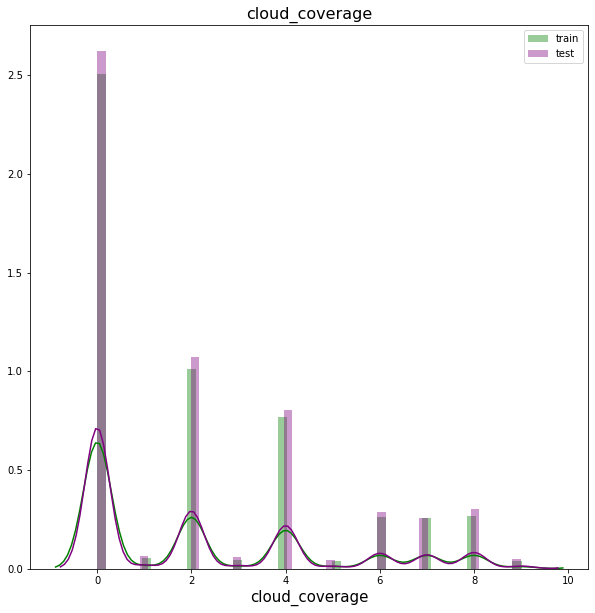

In [46]:
plot_dist_col('cloud_coverage')

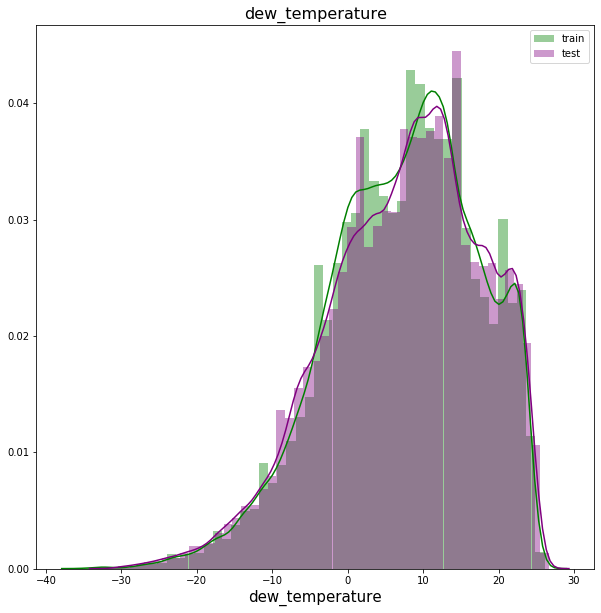

In [47]:
plot_dist_col('dew_temperature')

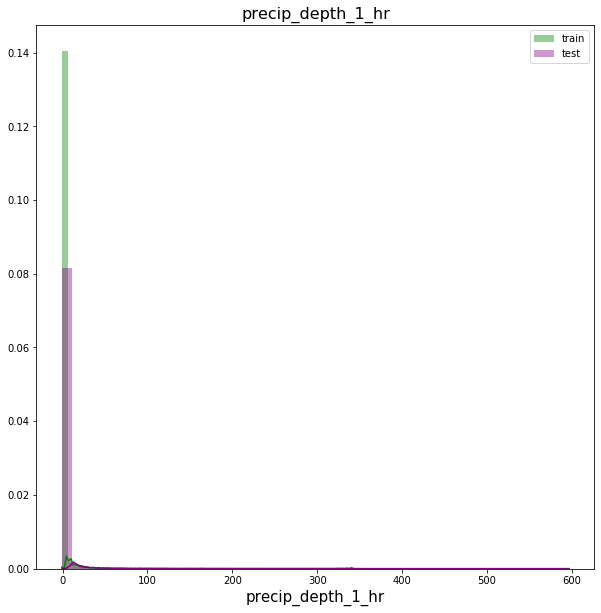

In [48]:
plot_dist_col('precip_depth_1_hr')

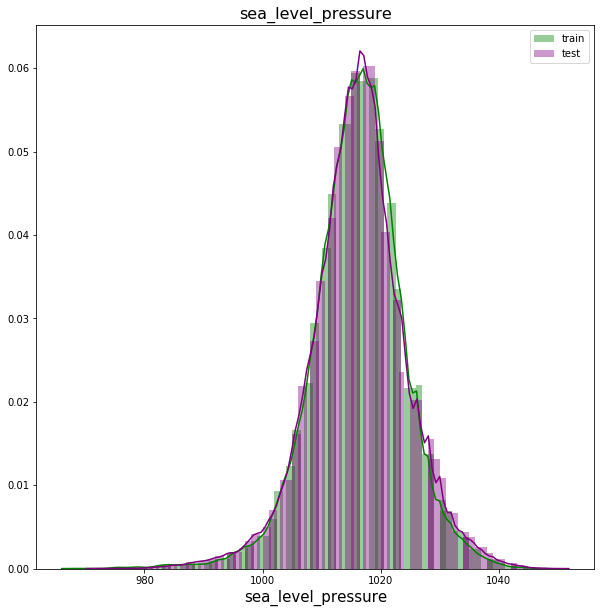

In [49]:
plot_dist_col('sea_level_pressure')

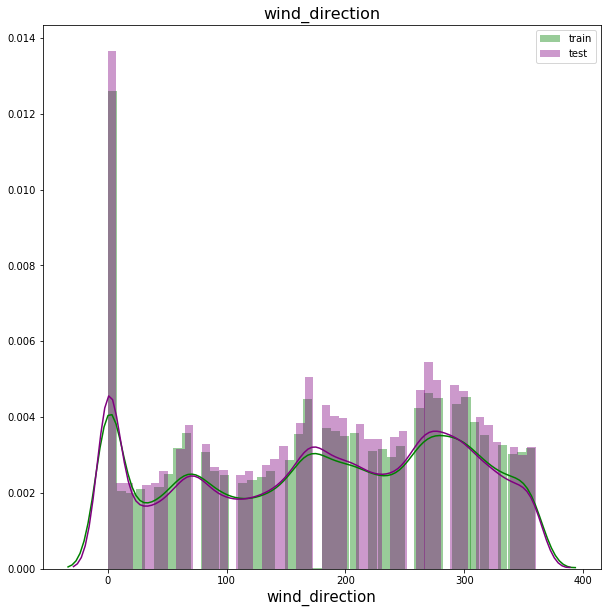

In [50]:
plot_dist_col('wind_direction')

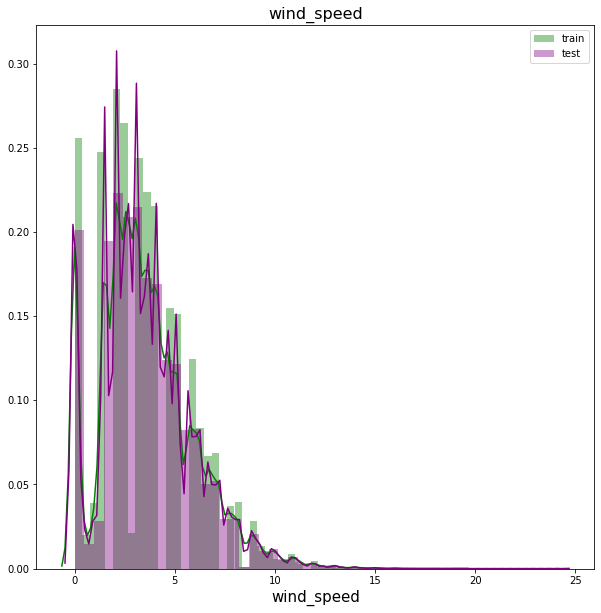

In [51]:
plot_dist_col('wind_speed')

강수량을 제외하고는 대부분 비슷한 그래프를 보여줍니다.

## Simple Single Series Analysis

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
#  seasonal_decompose(x, model='additive', filt=None, freq=None, two_sided=True, extrapolate_trend=0)
# Seasonal decomposition using moving averages
# 시계열의 분해

In [70]:
train_df.groupby(['timestamp'])['meter_reading'].sum()

timestamp
2016-01-01 00:00:00    4211283.500
2016-01-01 01:00:00    4251482.000
2016-01-01 02:00:00    1259595.375
2016-01-01 03:00:00    1009027.125
2016-01-01 04:00:00    1170655.500
                          ...     
2016-12-31 19:00:00    1086158.500
2016-12-31 20:00:00    1074138.875
2016-12-31 21:00:00    1120953.250
2016-12-31 22:00:00    1094064.750
2016-12-31 23:00:00    1057213.500
Name: meter_reading, Length: 8784, dtype: float32

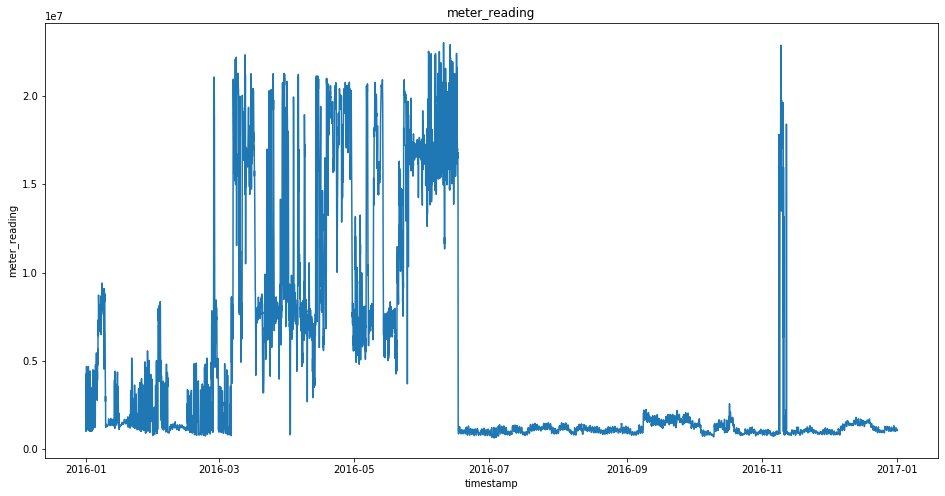

In [58]:
ts = train_df.groupby(['timestamp'])['meter_reading'].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts)

시간에 따른 meter_reading 변화량

In [83]:
ts.shape, ts.rolling(window=12, center=False).mean() # 데이터가 12개 미만인 값들은 NaN으로 표시 된다. # min_periods 를 사용하면 NaN값을 없앨 수 있다.

((8784,), timestamp
 2016-01-01 00:00:00             NaN
 2016-01-01 01:00:00             NaN
 2016-01-01 02:00:00             NaN
 2016-01-01 03:00:00             NaN
 2016-01-01 04:00:00             NaN
                            ...     
 2016-12-31 19:00:00    1.135387e+06
 2016-12-31 20:00:00    1.123890e+06
 2016-12-31 21:00:00    1.117342e+06
 2016-12-31 22:00:00    1.108906e+06
 2016-12-31 23:00:00    1.101317e+06
 Name: meter_reading, Length: 8784, dtype: float64)

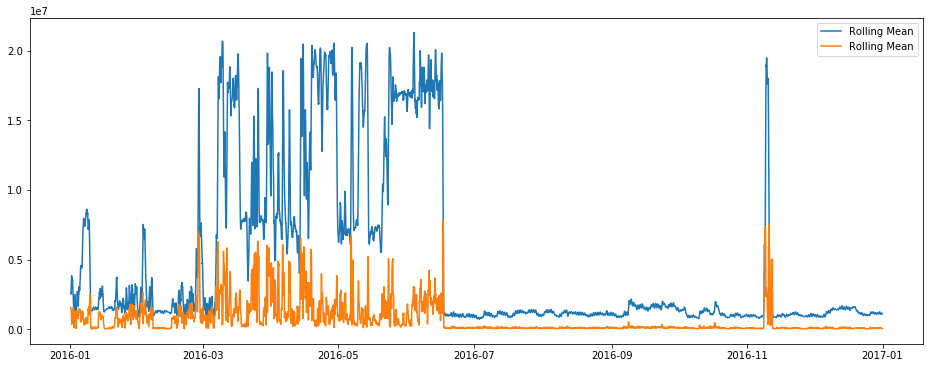

In [71]:
plt.figure(figsize = (16, 6))
plt.plot(ts.rolling(window=12, center=False).mean(), label='Rolling Mean'); # 이동 평균 계산.
plt.plot(ts.rolling(window=12, center=False).std(), label='Rolling Mean'); # 이동 분산 계산
plt.legend()

이동평균을 사용하는 이유는 복잡한 패턴을 평균 계산을 함으로써 패턴이 부드러워진다. <br>
아래와 같은 종류가 있으며 위에서 사용한 방법은 단순 이동 평균이다.
- 단순 이동 평균
- 선형 가중 평균 : 가중치
- 지수 이동 평균 : 가중치 more

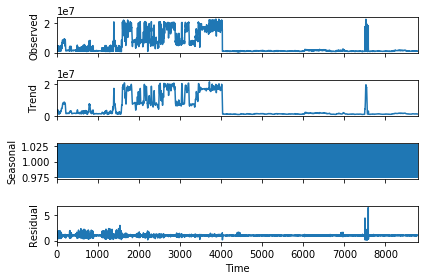

In [87]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='multiplicative')
fig = res.plot()

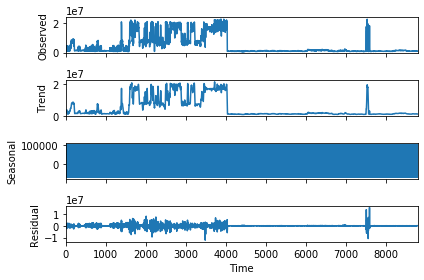

In [88]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()

## Outlier Distribution

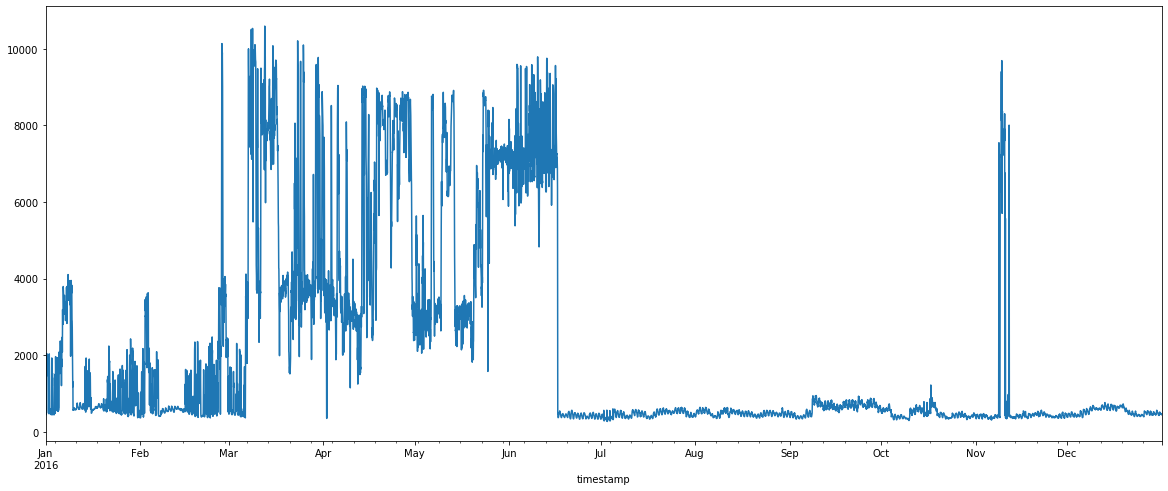

In [90]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

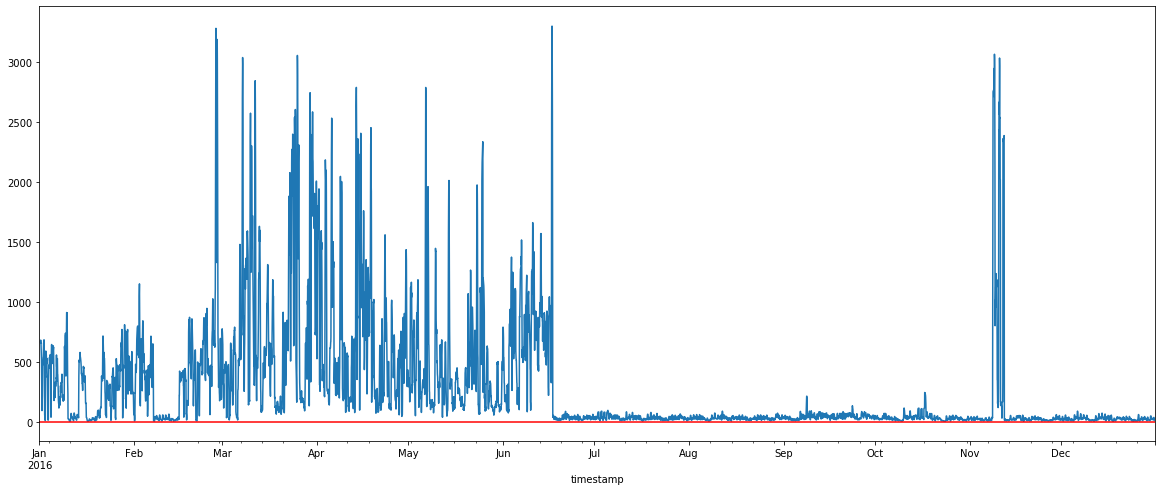

In [102]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
ax = plt.axhline(y = 0.009, color = 'red') # 별건 없고 빨간 줄 그어줌

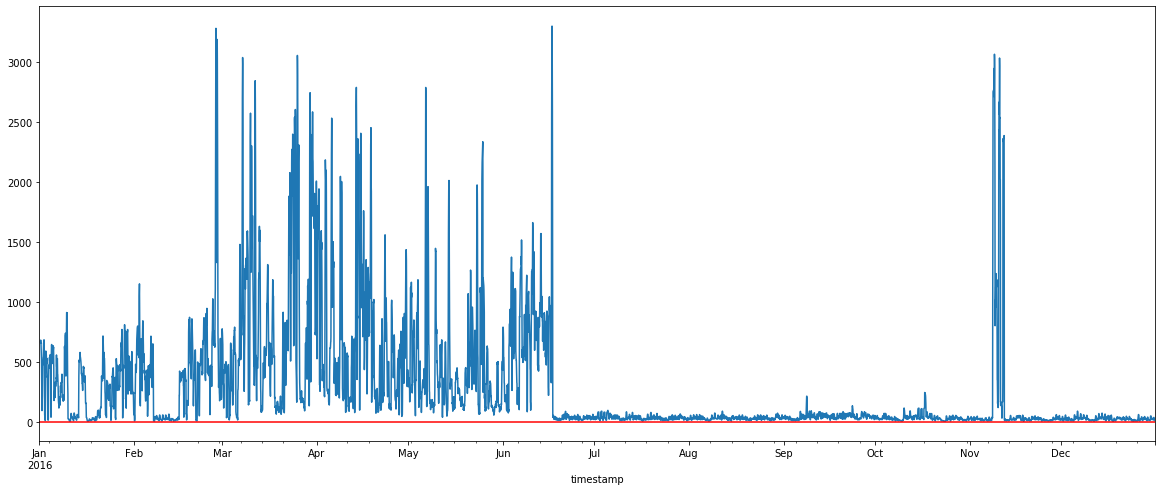

In [100]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color = 'red')
plt.axvspan(0, 905, color = 'green', alpha = 0.1) # Draw a vertical span (rectangle) from 'xmin' ro 'xmax'.
plt.axvspan(906, 1505, color = 'red', alpha = 0.1) # 뭘 기준으로 이렇게 했는지 모르겠네.. 보이지도 않고

##### Group data in a daily basis

In [118]:
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({
    0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'
})
daily_train = train_df.copy()
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train.head(5)

meter_reading
date       building_id meter                      
2016-01-01 0           electricity             0.0
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           1           electricity             0.0

In [120]:
daily_train.head(30)

meter_reading
date       building_id meter                      
2016-01-01 0           electricity             0.0
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           1           electricity             0.0
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           2           electricity             0.0
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           3           electricity             0.0
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           4           electricity             0.0
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           5           electricity             0.0
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           6           electricity             0.0
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           7           electricity             0.0
                       chilledwater            NaN

##### Aggregate the data for buildings

In [111]:
"""data로 묶인 데이터를 sum, mean, idxmax, max 를 계산한다."""
# date, meter로 묶는다.. sum, mean, idxmax, max 값이 알아서 계산된다. agg 의 기능인가본다.
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
# groupby 로 인해 사라진 index 값을 채워준다. 또한 columns 도 재정렬? 비스무리
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0) # ['', '', 'sum', 'mean', 'idxmax', 'max']
level_1 = daily_train_agg.columns.droplevel(1) # ['date', 'meter', 'meter_reading', 'meter_reading', 'meter_reading','meter_reading']
level_0 = ['' if x == '' else '-' + x for x in level_0] # ['', '', '-sum', '-mean', '-idxmax', '-max']
daily_train_agg.columns = level_1 + level_0 # groupby로 인해 나눠졌던 column 이 합쳐짐
daily_train_agg.rename_axis(None, axis = 1) # 
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05


In [112]:
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg

meter_reading                 \
                                  sum           mean   
date       meter                                       
2016-01-01 electricity   4.219648e+06    3037.903076   
           chilledwater  1.412169e+06    3090.084961   
           steam         6.873201e+07  218891.734375   
           hotwater      1.609989e+06   11180.481445   
2016-01-02 electricity   4.288951e+06    3085.576416   
...                               ...            ...   
2016-12-30 hotwater      2.077853e+06   14330.019531   
2016-12-31 electricity   5.066865e+06    3608.878418   
           chilledwater  2.102037e+06    4246.539551   
           steam         1.718295e+07   53033.812500   
           hotwater      2.086813e+06   14391.812500   

                                                                         
                                                   idxmax           max  
date       meter                                                         
2016-01-01 electricity     (2016-01-01, 803, electricity)  1.160372e+05  
           chilledwater  (2016-01-01, 1289, chilledwater)  1.042116e+05  
           steam                (2016-01-01, 1099, steam)  5.095080e+07  
           hotwater          (2016-01-01, 1331, hotwater)  2.198245e+05  
2016-01-02 electricity     (2016-01-02, 803, electricity)  1.157768e+05  
...                                                   ...           ...  
2016-12-30 hotwater          (2016-12-30, 1021, hotwater)  5.124206e+05  
2016-12-31 electricity     (2016-12-31, 799, electricity)  1.343883e+05  
           chilledwater    (2016-12-31, 50, chilledwater)  8.256347e+04  
           steam                (2016-12-31, 1168, steam)  1.324875e+06  
           hotwater          (2016-12-31, 1021, hotwater)  4.132599e+05  

[1464 rows x 4 columns]

In [113]:
daily_train_agg = daily_train_agg.reset_index()
daily_train_agg

date         meter meter_reading                 \
                                         sum           mean   
0     2016-01-01   electricity  4.219648e+06    3037.903076   
1     2016-01-01  chilledwater  1.412169e+06    3090.084961   
2     2016-01-01         steam  6.873201e+07  218891.734375   
3     2016-01-01      hotwater  1.609989e+06   11180.481445   
4     2016-01-02   electricity  4.288951e+06    3085.576416   
...          ...           ...           ...            ...   
1459  2016-12-30      hotwater  2.077853e+06   14330.019531   
1460  2016-12-31   electricity  5.066865e+06    3608.878418   
1461  2016-12-31  chilledwater  2.102037e+06    4246.539551   
1462  2016-12-31         steam  1.718295e+07   53033.812500   
1463  2016-12-31      hotwater  2.086813e+06   14391.812500   

                                                      
                                idxmax           max  
0       (2016-01-01, 803, electricity)  1.160372e+05  
1     (2016-01-01, 1289, chilledwater)  1.042116e+05  
2            (2016-01-01, 1099, steam)  5.095080e+07  
3         (2016-01-01, 1331, hotwater)  2.198245e+05  
4       (2016-01-02, 803, electricity)  1.157768e+05  
...                                ...           ...  
1459      (2016-12-30, 1021, hotwater)  5.124206e+05  
1460    (2016-12-31, 799, electricity)  1.343883e+05  
1461    (2016-12-31, 50, chilledwater)  8.256347e+04  
1462         (2016-12-31, 1168, steam)  1.324875e+06  
1463      (2016-12-31, 1021, hotwater)  4.132599e+05  

[1464 rows x 6 columns]

In [114]:
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
print(level_0, level_1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
print(level_0)

Index(['', '', 'sum', 'mean', 'idxmax', 'max'], dtype='object') Index(['date', 'meter', 'meter_reading', 'meter_reading', 'meter_reading',
       'meter_reading'],
      dtype='object')
['', '', '-sum', '-mean', '-idxmax', '-max']


In [116]:
daily_train_agg.columns = level_1 + level_0
daily_train_agg

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05
...,...,...,...,...,...,...
1459,2016-12-30,hotwater,2.077853e+06,14330.019531,"(2016-12-30, 1021, hotwater)",5.124206e+05
1460,2016-12-31,electricity,5.066865e+06,3608.878418,"(2016-12-31, 799, electricity)",1.343883e+05
1461,2016-12-31,chilledwater,2.102037e+06,4246.539551,"(2016-12-31, 50, chilledwater)",8.256347e+04
1462,2016-12-31,steam,1.718295e+07,53033.812500,"(2016-12-31, 1168, steam)",1.324875e+06


In [117]:
daily_train_agg.rename_axis(None, axis = 1)
daily_train_agg

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05
...,...,...,...,...,...,...
1459,2016-12-30,hotwater,2.077853e+06,14330.019531,"(2016-12-30, 1021, hotwater)",5.124206e+05
1460,2016-12-31,electricity,5.066865e+06,3608.878418,"(2016-12-31, 799, electricity)",1.343883e+05
1461,2016-12-31,chilledwater,2.102037e+06,4246.539551,"(2016-12-31, 50, chilledwater)",8.256347e+04
1462,2016-12-31,steam,1.718295e+07,53033.812500,"(2016-12-31, 1168, steam)",1.324875e+06


In [123]:
fig_total = px.line(daily_train_agg, x = 'date', y = 'meter_reading-sum', color = 'meter', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

각 에너지 측면에 대해 계산된 합은 일부 비정상적인 값을 보여줍니다.

In [124]:
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh value per energy aspect')
fig_maximum.show()

각 일별 및 각 에너지 측면의 최대값을 살펴보면 (일별 및 에너지 측면에 대한) 단일 건물만이 한계 최고점을 초래하고 있음을 알 수 있다.

## Identifying outliers

In [125]:
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05,803
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05,1289
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07,1099
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05,1331
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05,803


In [135]:
def show_building(building, energy_aspects=None):
    fig = px.line(daily_train.loc[(slice(None), building, slice(None)), :].reset_index(),
                  x='date',
                  y='meter_reading',
                  color='meter',
                  render_mode='svg')
    if energy_aspects:
        if 'electricity' not in energy_aspects:
            fig['data'][0].visible = 'legendonly'
        if 'chilledwater' not in energy_aspects:
            fig['data'][1].visible = 'legendonly'
        if 'steam' not in energy_aspects:
            fig['data'][2].visible = 'legendonly'
        if 'hotwater' not in energy_aspects:
            fig['data'][3].visible = 'legendonly'
    fig.update_layout(title='Building ID: {}'.format(building))        
    fig.show()
    display(building_metadata[building_metadata['building_id']==building])

##### Electricity

In [136]:
print('Number of days that a building has the maximum electricity consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].value_counts())

Number of days that a building has the maximum electricity consumption of all the buildings:

803     192
801      65
799      58
1088     49
993       1
794       1
Name: building_id_max, dtype: int64


단 6개의 건물이 전기의 최대값을 야기한다.

In [137]:
daily_train_electricity = daily_train_agg[daily_train_agg['meter']=='electricity'].copy()
daily_train_electricity['building_id_max'] = pd.Categorical(daily_train_electricity['building_id_max'])
fig_daily_electricity = px.scatter(daily_train_electricity,
                                   x='date',
                                   y='meter_reading-max',
                                   color='building_id_max',
                                   render_mode='svg')
fig_daily_electricity.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_electricity.show()

##### Chilledwater

In [139]:
print('Number of days that a building has the maximum chilledwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].value_counts())

Number of days that a building has the maximum chilledwater consumption of all the buildings:

1284    134
76       92
1258     41
1289     38
778      37
1088     10
29       10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64


단 10개의 건물이 냉수의 최대값을 야기.

In [140]:
daily_train_chilledwater = daily_train_agg[daily_train_agg['meter']=='chilledwater'].copy()
daily_train_chilledwater['building_id_max'] = pd.Categorical(daily_train_chilledwater['building_id_max'])
fig_daily_chilledwater = px.scatter(daily_train_chilledwater,
                                    x='date',
                                    y='meter_reading-max',  
                                    color='building_id_max', 
                                    render_mode='svg')
fig_daily_chilledwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_chilledwater.show()

##### Steam

In [141]:
print('Number of days that a building has the maximum steam consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].value_counts())

Number of days that a building has the maximum steam consumption of all the buildings:

1099    158
1197    101
1168    100
1148      7
Name: building_id_max, dtype: int64


단 4개의 건물이 증기의 최대값을 야기.

In [142]:
daily_train_steam = daily_train_agg[daily_train_agg['meter']=='steam'].copy()
daily_train_steam['building_id_max'] = pd.Categorical(daily_train_steam['building_id_max'])
fig_daily_steam = px.scatter(daily_train_steam,
                             x='date',
                             y='meter_reading-max',
                             color='building_id_max',
                             render_mode='svg')
fig_daily_steam.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_steam.show()

##### Hot water

In [143]:
print('Number of days that a building has the maximum hotwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'hotwater']['building_id_max'].value_counts())

Number of days that a building has the maximum hotwater consumption of all the buildings:

1021    229
1331    120
1317      7
794       7
1323      1
1252      1
1232      1
Name: building_id_max, dtype: int64


단 7개의 건물이 온수의 최대값을 야기.

In [144]:
daily_train_hotwater = daily_train_agg[daily_train_agg['meter']=='hotwater'].copy()
daily_train_hotwater['building_id_max'] = pd.Categorical(daily_train_hotwater['building_id_max'])
fig_daily_hotwater = px.scatter(daily_train_hotwater,
                                x='date',
                                y='meter_reading-max',
                                color='building_id_max',
                                render_mode='svg')
fig_daily_hotwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_hotwater.show()

Taking only the buildings that consume more than the others, could be seen that there are a lot of measure scale errors. <br>
The error could be:

The meter is not configured correctly. E.g., a bad voltage or current primary to secondary ratio.
The software has not the units configured correctly. E.g., MJ/kg for steam.
The software has not the decimal digits configured correctly.
Using a power variable instead of an energy one.
The measure could be done with an unique meter, or the sum of several of them.

Some changes over time, values go to zero or the scale is changed, indicates that some buildings have more than one meter. One error in one meter and the overall measure is garbage.

This notebook has only analised the outliers that influence the maximum consumption in a daily basis. This is only the tip of the iceberg. A sound analysis should be done to detect and correct these outliers.

A solution to avoid scale errors is to normalize the values from 0 to 1, for each building and for each energy aspect.

> 쏼라쏼라 나중에
